# 1. Introduction
## Problem Overview
In this notebook, I attempt to create a predictive model to classify the origin of a wine, based off the quantities of 13 constituents found in wine from 3 different cultivars from a region in Italy. <br/>
This could have some potential to detect a fake version of a wine. Without more context on the dataset it is hard to say how exactly this would apply, however it may be along the lines that 1 or 2 of the cultivars are producing highend wines whilst the other is producing fakes of those wines, we may be able to apply data science techniques to classify if the wine is from the real cultivar or the fake one. [3] <br/>
There may also be potential to provide insight to which wine a customer should by, ie. if you were to run a wine that isn't from one of the 3 cultivars, that a buyer liked, there is a chance that they would prefer the wine from the cultivar this model predicts (though this would be more practical if there were a larger group of cultivars and there are arguably more suitable methods for this, however those other methods would require more and different data from other parties that a client may not have access to). [2]




<img src="https://th.bing.com/th/id/R.92a794a65964e413985375482e48a579?rik=Y4qDlUTWqQvDLQ&riu=http%3a%2f%2fblog.juicegrape.com%2fwp-content%2fuploads%2f2017%2f07%2fiStock-665345390-2.jpg&ehk=7ubWnXdtHoPg%2f5ui7I9ltcUWKJ9o6jBg8IeIDtoBVeo%3d&risl=&pid=ImgRaw&r=0" />




## Proposed Solution
The dataset's samples are labled, which allows for a supervised learning approach to this classification problem. I plan to create a few models to see which performs the best, these will be a decision tree, a random forest, and a MLP. I will assess the models based primarily off of accuracy (on unseen samples), but also on the complexity of the model ie, a single Decision tree may be only slightly out performed by a large random forest so it may be better to stick to a single tree. I will investigate whether or not it is suitable to apply PCA to the data, by looking at the cumulative explained variance ratio, and potentially also training a model on both the original data and the PCA data.


# 2. Data Description and Exploratory Analysis
I will be using a dataset from https://archive.ics.uci.edu/dataset/109/wine.<br/>
The dataset consists of 178 samples, each with 13 attributes that correspond to the quantities of different constituents found in all the wines, as well as a label ("Target") attribute 1-3 that represents the cultivar the sample is from. <br/>
The 13 quantities are:<br/>
1) Alcohol <br/>
2) Malic acid<br/>
3) Ash<br/>
4) Alcalinity of ash  <br/>
5) Magnesium<br/>
6) Total phenols<br/>
7) Flavanoids<br/>
8) Nonflavanoid phenols<br/>
9) Proanthocyanins<br/>
10) Color intensity<br/>
11) Hue<br/>
12) OD280/OD315 of diluted wines (Protein concentration)<br/>
13) Proline <br/>

All of the features are continuous, with no clear fixed natural range.

### Importing Libraries

In [1]:
# data manipulation
import numpy as np
import pandas as pd
# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
# models
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
# utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import export_text
# performance statistics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score


### Load the Data
Load the data into a pandas dataframe, and assign relevant column names.

In [2]:
# all the column headers
columns = ["Target", "Alcohol", "Malic Acid", "Ash", "Alcalinity", "Magnesium", "Phenols", "Flavanoids", "Nonflavanoids", "Proanthocynins", "Color", "Hue", "Od280/OD315", "Proline"]
# load the data to a pandas dataFrame and assign the column names
data_frame = pd.read_csv("/content/wine.csv", names=columns)

Split the data into features and labels

In [3]:
# create a replica of the data frame that can be used and manipulated independently
feature_frame = data_frame.copy()
# remove the target column and store it in label_frame
label_frame = feature_frame.pop("Target")

Here I will look at the head of the label and feature frame to get an initial idea for the data, and ensure that the data has been loaded correctly.

In [4]:
# print of the first 5 samples
print(feature_frame.head())
print()
print(label_frame.head())

   Alcohol  Malic Acid   Ash  Alcalinity  Magnesium  Phenols  Flavanoids  \
0    14.23        1.71  2.43        15.6        127     2.80        3.06   
1    13.20        1.78  2.14        11.2        100     2.65        2.76   
2    13.16        2.36  2.67        18.6        101     2.80        3.24   
3    14.37        1.95  2.50        16.8        113     3.85        3.49   
4    13.24        2.59  2.87        21.0        118     2.80        2.69   

   Nonflavanoids  Proanthocynins  Color   Hue  Od280/OD315  Proline  
0           0.28            2.29   5.64  1.04         3.92     1065  
1           0.26            1.28   4.38  1.05         3.40     1050  
2           0.30            2.81   5.68  1.03         3.17     1185  
3           0.24            2.18   7.80  0.86         3.45     1480  
4           0.39            1.82   4.32  1.04         2.93      735  

0    1
1    1
2    1
3    1
4    1
Name: Target, dtype: int64


It looks like all the data has been loaded in and allocated to the correct columns. <br/>



Next I will look at the composition of the classes, visualizing it with a pie chart.

   Target  proportion
0       2    0.398876
1       1    0.331461
2       3    0.269663


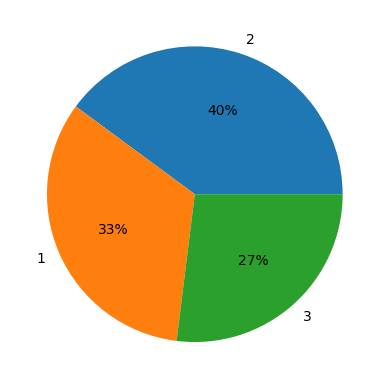

In [5]:
# get the proportion of each class
label_dist = label_frame.value_counts(normalize=True).reset_index()
print(label_dist)
# plot a pie chart with that data
plt.pie(label_dist["proportion"], labels=label_dist["Target"], autopct='%.000f%%');

From this we can see that there is a fairly large difference between the proportion of 2 and 3 classes, however I am confident that there are enough samples to train and test a model that is accurate to all classes, and shouldn't be skewed to a particular class.

Next i will get the descriptive statistics of all the features

In [6]:
# get the descriptive stats
description = feature_frame.describe()
description

Alcohol  Malic Acid         Ash  Alcalinity   Magnesium     Phenols  \
count  178.000000  178.000000  178.000000  178.000000  178.000000  178.000000   
mean    13.000618    2.336348    2.366517   19.494944   99.741573    2.295112   
std      0.811827    1.117146    0.274344    3.339564   14.282484    0.625851   
min     11.030000    0.740000    1.360000   10.600000   70.000000    0.980000   
25%     12.362500    1.602500    2.210000   17.200000   88.000000    1.742500   
50%     13.050000    1.865000    2.360000   19.500000   98.000000    2.355000   
75%     13.677500    3.082500    2.557500   21.500000  107.000000    2.800000   
max     14.830000    5.800000    3.230000   30.000000  162.000000    3.880000   

       Flavanoids  Nonflavanoids  Proanthocynins       Color         Hue  \
count  178.000000     178.000000      178.000000  178.000000  178.000000   
mean     2.029270       0.361854        1.590899    5.058090    0.957449   
std      0.998859       0.124453        0.572359    2.318286    0.228572   
min      0.340000       0.130000        0.410000    1.280000    0.480000   
25%      1.205000       0.270000        1.250000    3.220000    0.782500   
50%      2.135000       0.340000        1.555000    4.690000    0.965000   
75%      2.875000       0.437500        1.950000    6.200000    1.120000   
max      5.080000       0.660000        3.580000   13.000000    1.710000   

       Od280/OD315      Proline  
count   178.000000   178.000000  
mean      2.611685   746.893258  
std       0.709990   314.907474  
min       1.270000   278.000000  
25%       1.937500   500.500000  
50%       2.780000   673.500000  
75%       3.170000   985.000000  
max       4.000000  1680.000000

It's nice to have the hard numbers, however i would also like an easier visualization so i will plot a boxplot for all of the features

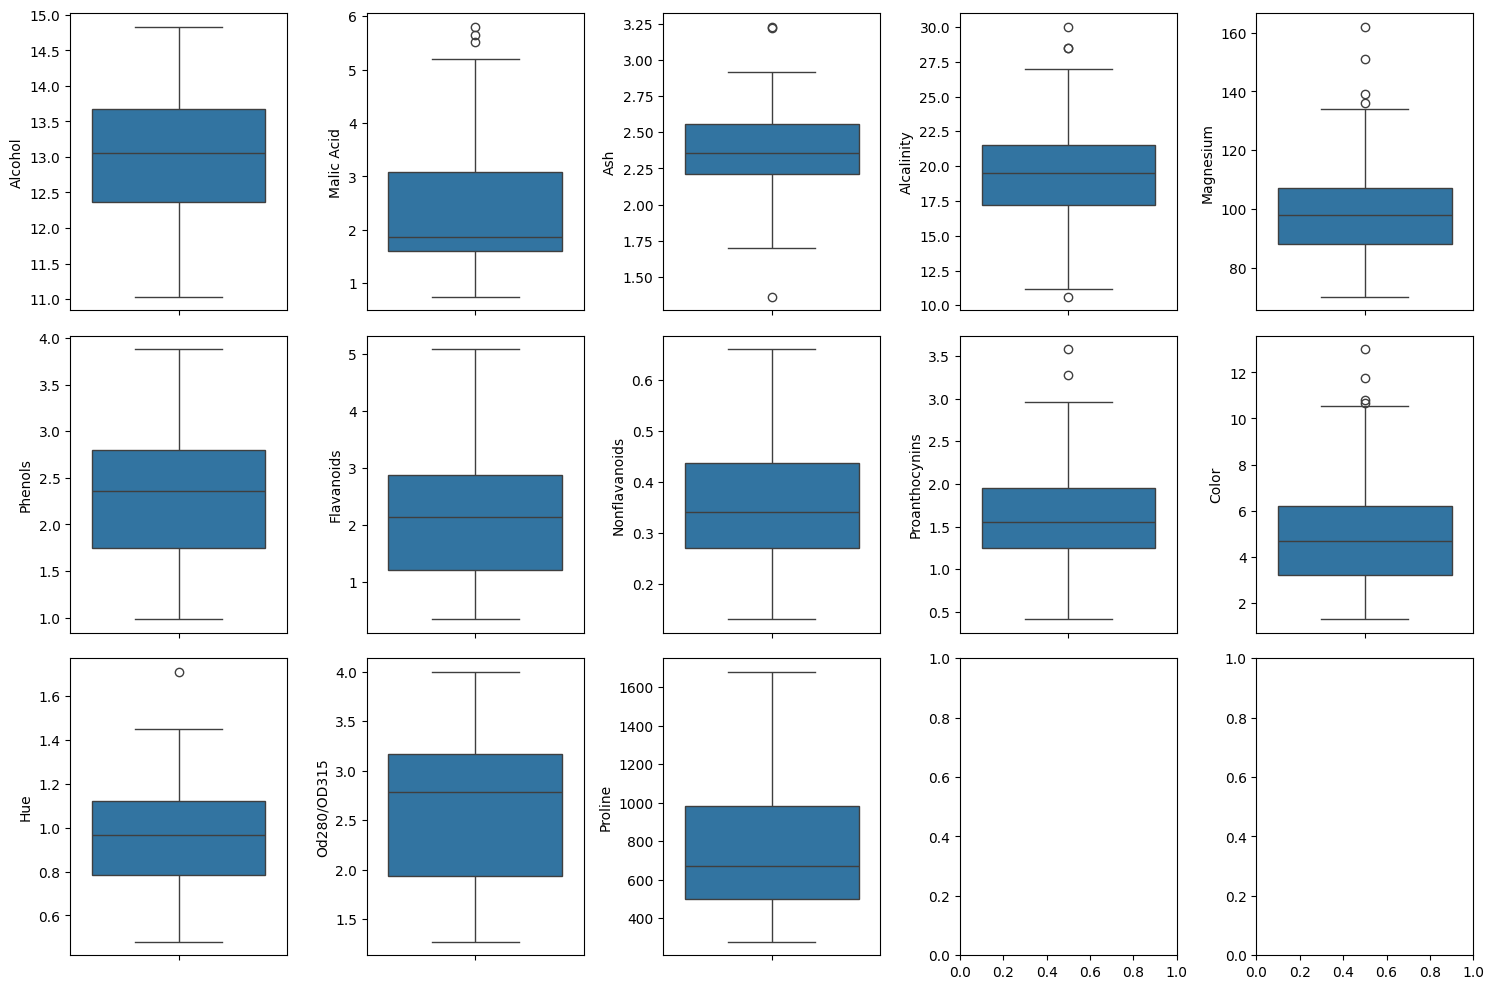

In [7]:
# create subplots so that all the features can be plotted together
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15,10))
# flatten the subplot's indexes so that they can be more easily referenced
axes = axes.flatten()
# enumerate through the columns
for index, column in enumerate (feature_frame.columns):
  # for each feature plot the box plot
  sns.boxplot(feature_frame[column], ax=axes[index])
# ensure that there is no overlap between the plots
plt.tight_layout()
plt.show()

From this we can see that there are a few outliers, most are fairly reasonable however, there is in magnesium there is one that is almost 4.4 standard deviations from the mean, so i will just look into it, and see if that sample is responsible for any other outliers, indicating that it is a bad sample.

In [8]:
# get the sample where Magnesium equal 162.0
data_frame[data_frame["Magnesium"] == 162.0]


Target  Alcohol  Malic Acid  Ash  Alcalinity  Magnesium  Phenols  \
95       2    12.47        1.52  2.2        19.0        162      2.5   

    Flavanoids  Nonflavanoids  Proanthocynins  Color   Hue  Od280/OD315  \
95        2.27           0.32            3.28    2.6  1.16         2.63   

    Proline  
95      937

This sample is also an outlier in Proanthocynins, however it is fine for all other features, so I am comfortable leaving it in, the only reason I may take it out however is that it is in class two which has the most representation, so its some what expendable, however this is a fairly small dataset already, so I'm just going to leave it in.

Next I will look at the distributions of the features between classes, to see if there are any notable differences between classes within a feature. <br/>
First i will plot box plots for seperate classes then i will plot a line histogram.

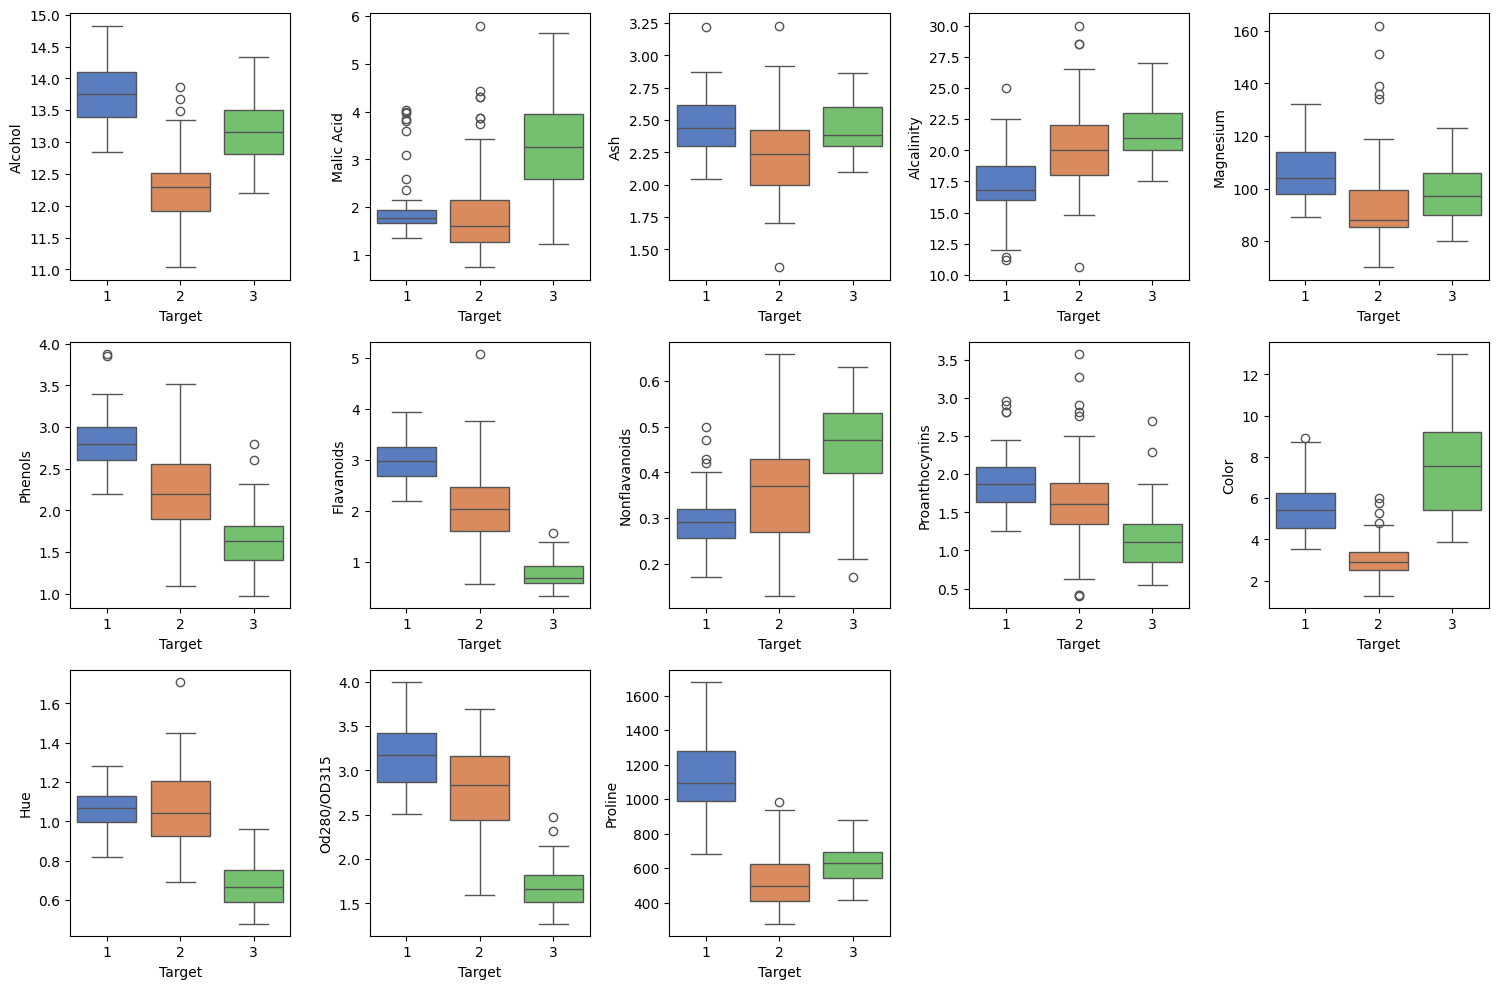

In [37]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15,10))
axes = axes.flatten()
for index, column in enumerate (feature_frame.columns):
  # create a box plot that seperates out the classes, legend turned to false as A. it is redundant as the axis are labeled and B. it seemed to get in the way of some of the plots.
  sns.boxplot(data_frame, y=column, x="Target", hue = "Target", ax=axes[index], palette="muted", legend=False)

# Remove extra plots to neaten it up a bit.
for i in range(len(feature_frame.columns), len(axes)):
    axes[i].remove()
plt.tight_layout()
plt.show()

From this we can see that a few features lead to a lot of outliers for certail classes (Malic acid), this means that if they are used to predict with they could result in a lot of overlap and then incorrect predictions. We can also see that Flavanoids does a particularly good job of differentiating classeswith no overlap in interquartile ranges, alcohol and Phenols are also quite effective at this but is certainly not as good. Interestingly Od280/OD312 seems to almost completely differentiate cultivars 1 and 3, at least for all the wines sampled, with only one *outlier* having a potential clash with the *minimum* value for 1, this could be very powerfull for a decision tree that could more or less cut a clean line between the two.

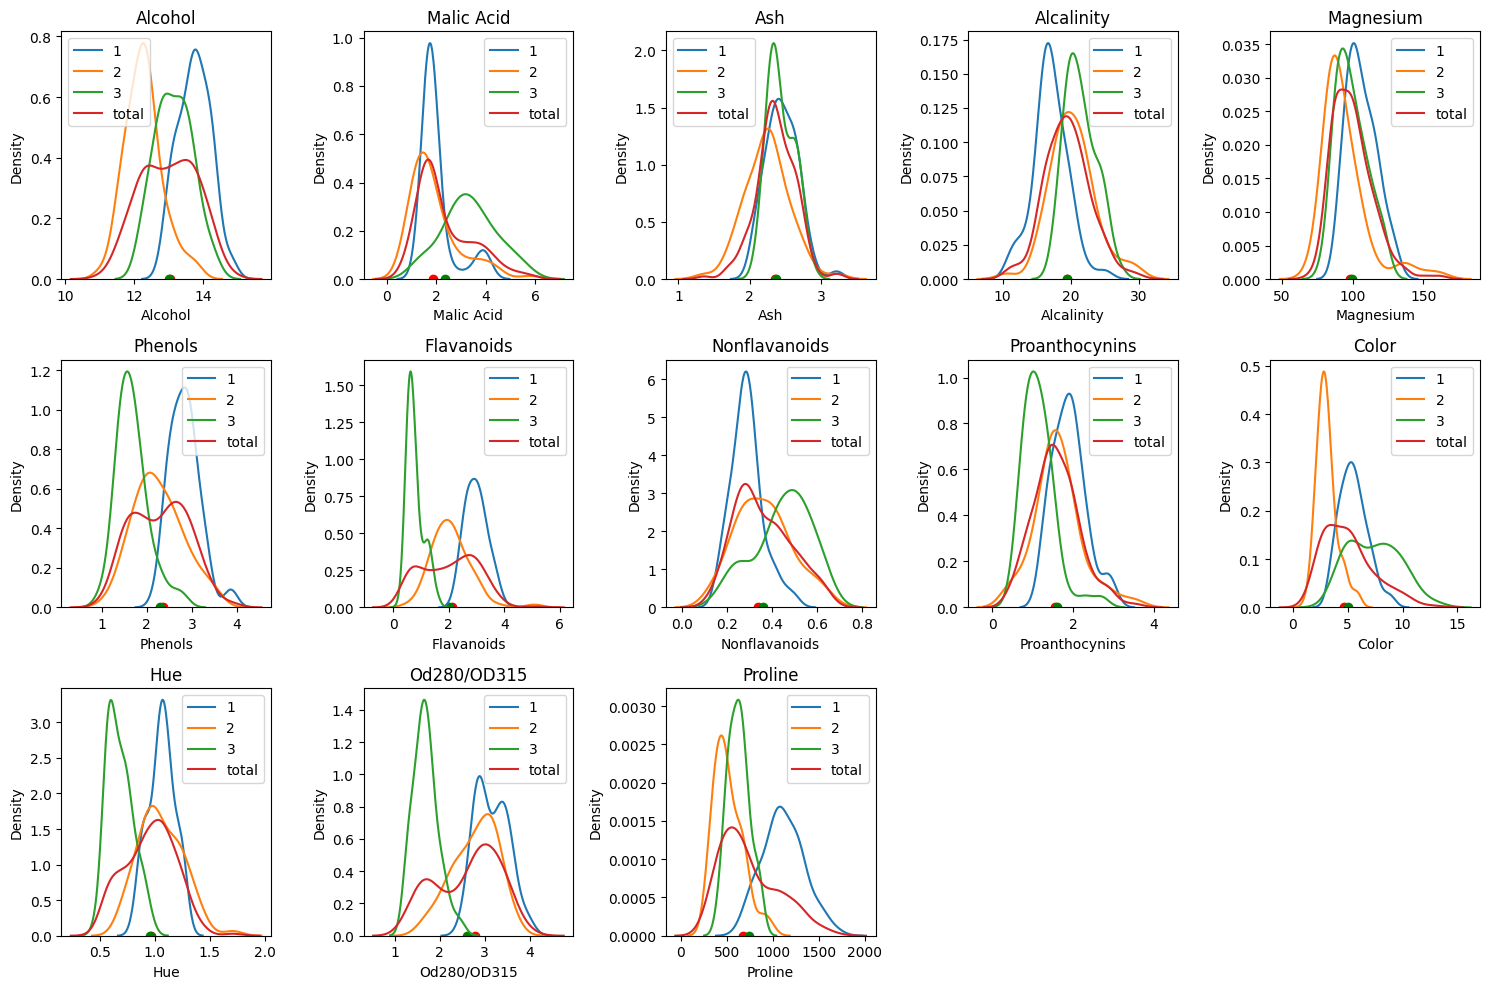

In [38]:
# make subplots
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15,10))
# flatten the indexes so they are easier to reference
axes = axes.flatten()
# get the relevant descriptive stats, to help decide if standardization is viable
medians = description.loc["50%"]
means = description.loc["mean"]
# group the data based of off Target so that each individual class can be handeled seperatly
grouped = data_frame.groupby(["Target"])
# loop through the groups / classes
for group_name, group in grouped:
  # remove the Target column as we don't want to try an plot it
  group = group.drop("Target", axis=1)
  # loop through all the columns
  for index, column in enumerate (group.columns):
    # plot the distribution of the feature for this class
    sns.kdeplot(group[column], ax=axes[index], label=group_name[0])

# loop through the columns
for index, column in enumerate (group.columns):
  # plot the distribution of the feature overall
  sns.kdeplot(feature_frame[column], ax=axes[index], label="total")
  # set the title
  axes[index].set_title(column)
  # plot the median and mean so i can see how close they are
  axes[index].scatter(medians[index], 0, color="red")
  axes[index].scatter(means[index], 0, color="green")
  # add a key to the graphs
  axes[index].legend()

# Remove extra plots to neaten it up a bit.
for i in range(len(feature_frame.columns), len(axes)):
    axes[i].remove()
plt.tight_layout()
plt.show()

from this I can see that Ash is a bad indicator, however, Flavanoids is a good indicator with distinct peaks, and class 3 can be fairly accurately predicted based off of Hue, similar to class 2 which can be largely identified by Color.



Now I will plot a scatter matrix to look for any relationships between features, or useful combinations to predict features.

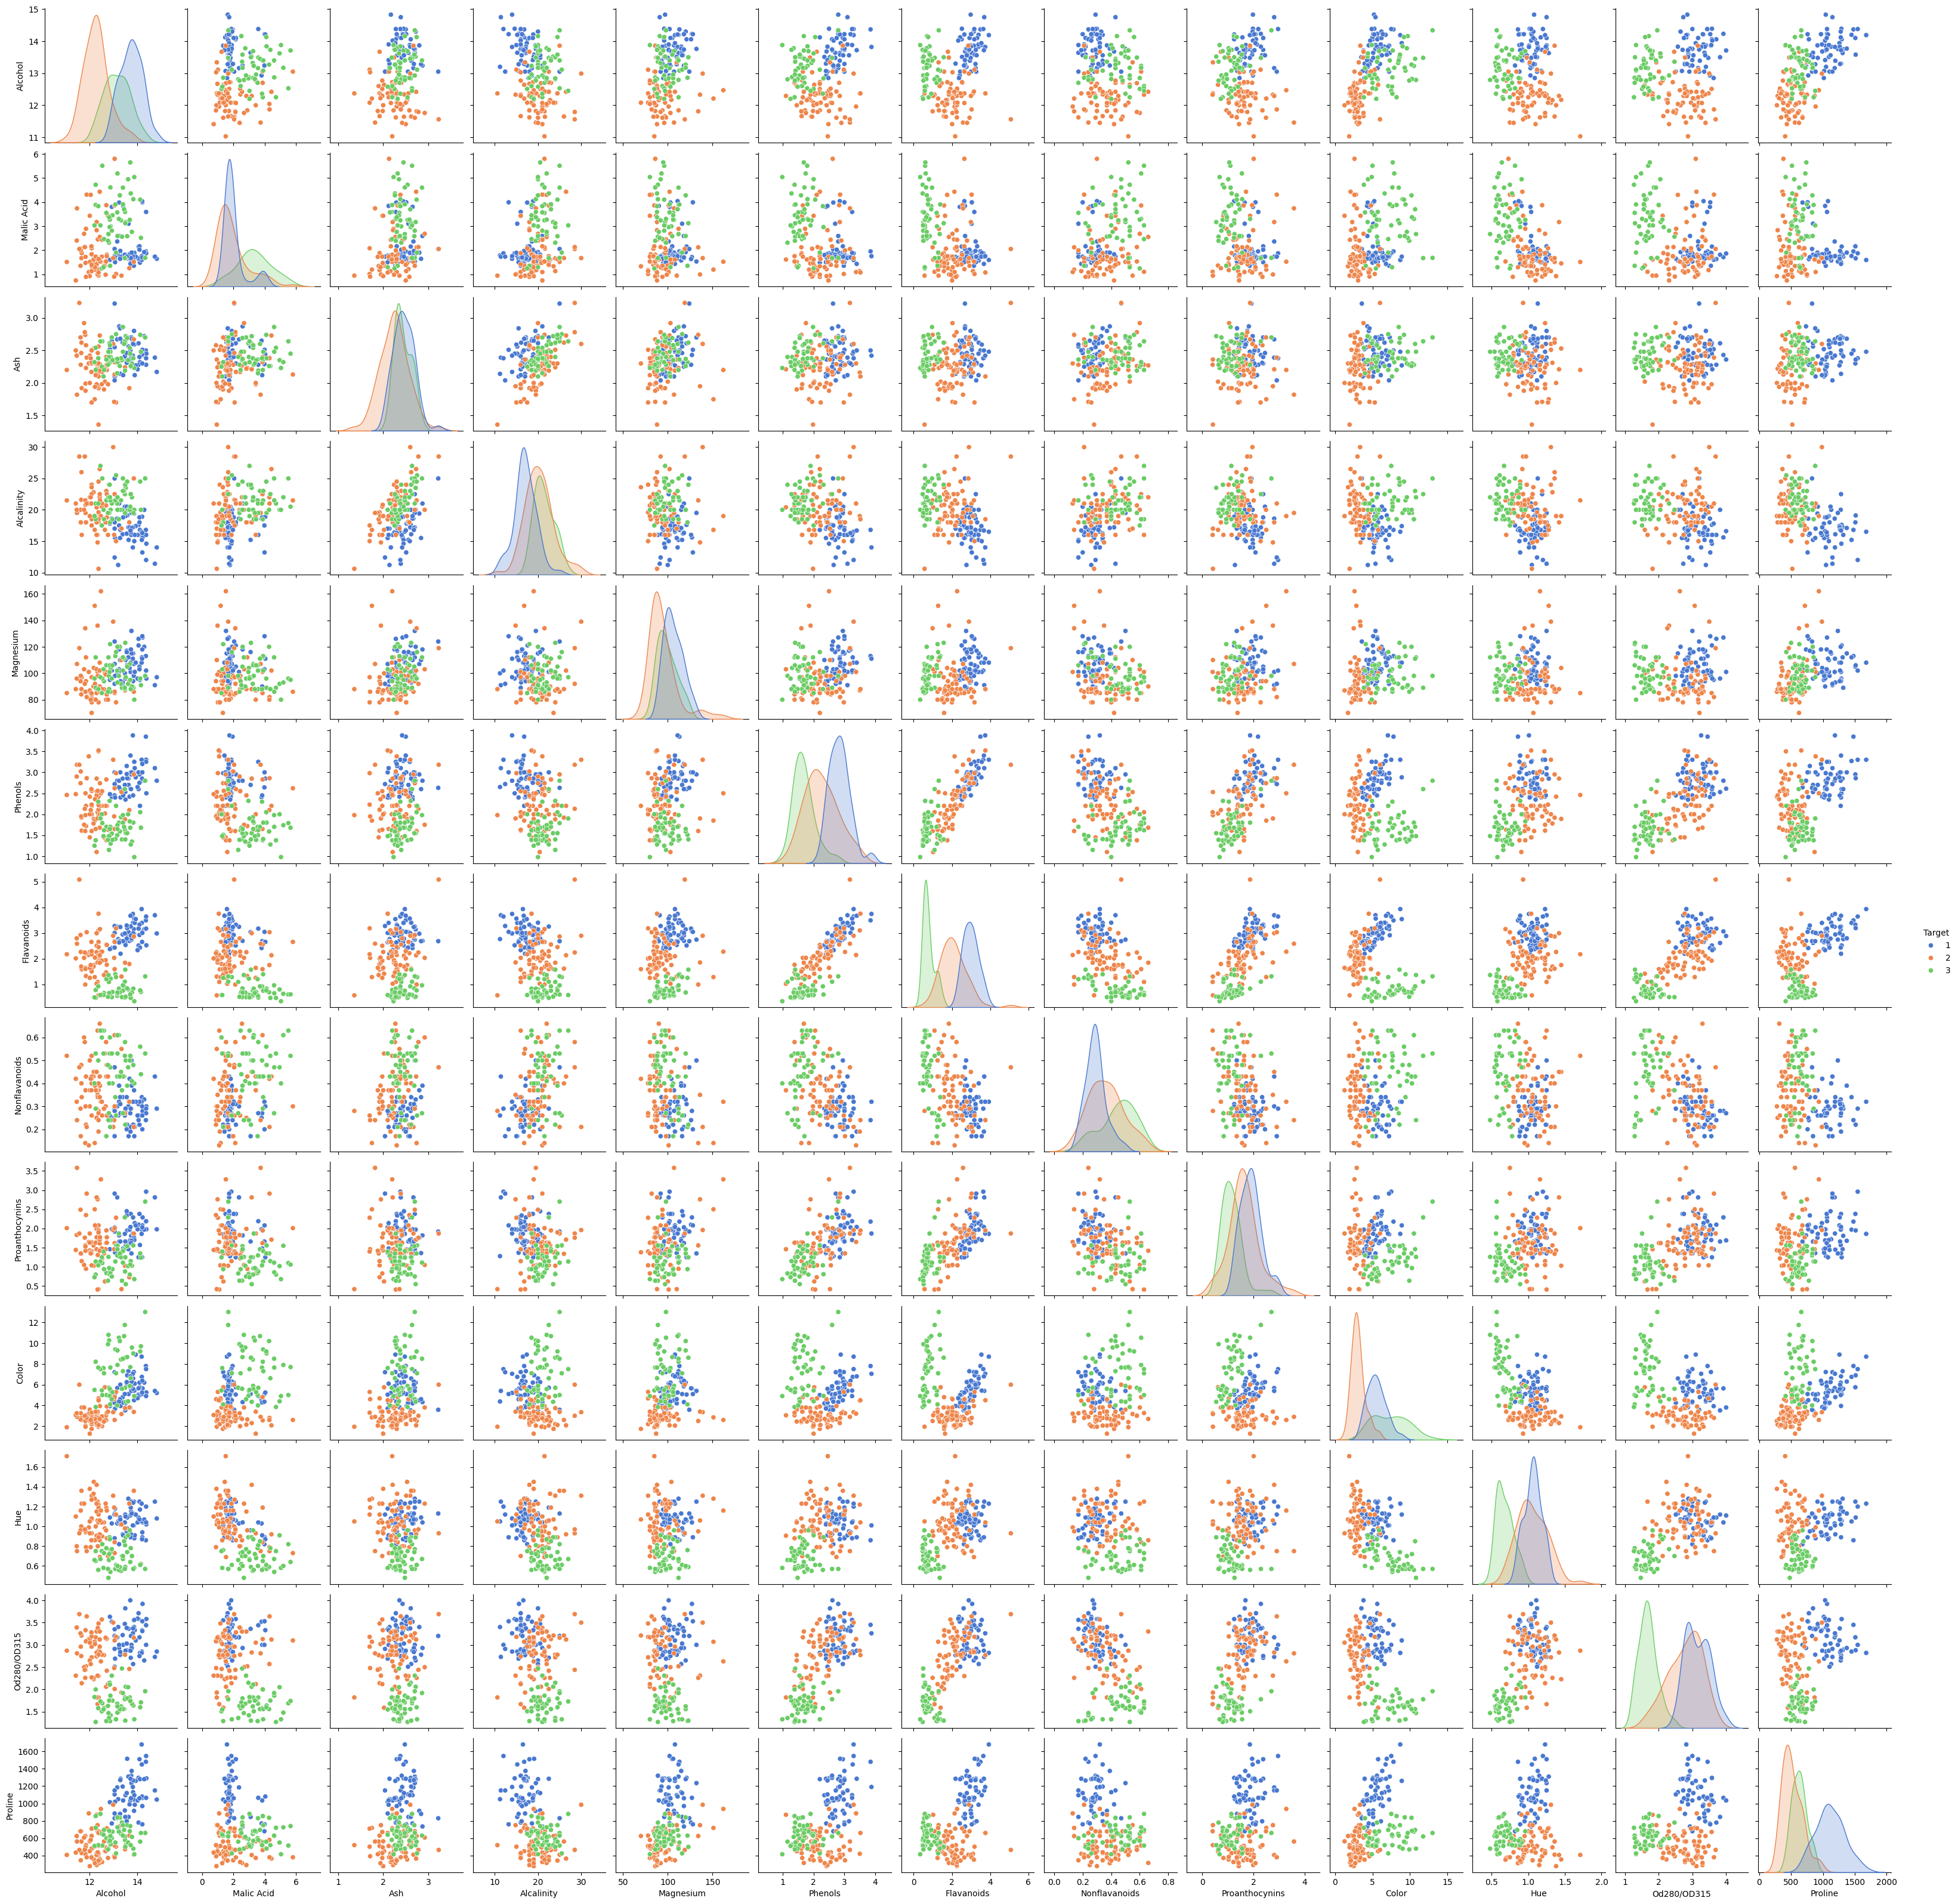

In [10]:
sns.pairplot(data_frame, hue="Target", palette="muted")

From this we can see that flavanoids and Phenols have a strong relationship, we can also see that there is more overlap between the classes on the hue and colour features, than I thought. Though the combination of Proline and Od2 is quite effective to distinguish the classes.

To get a more detailed look at the relationships between features I will plot a heat map of the correlation.

<Axes: >

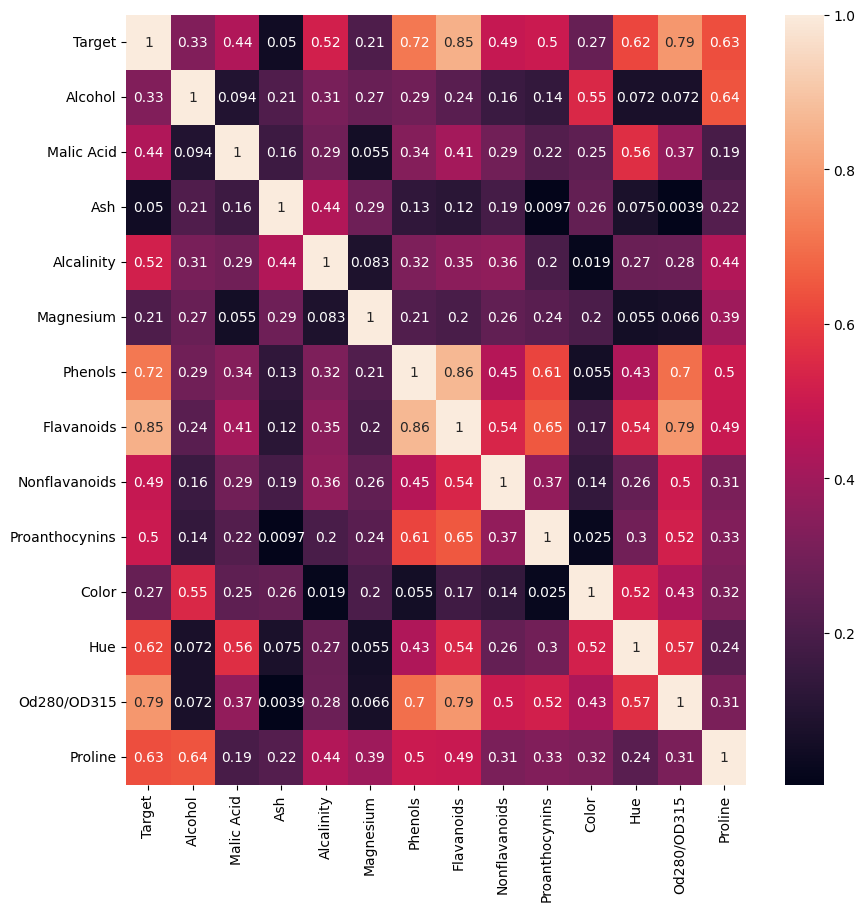

In [11]:
plt.figure(figsize=(10,10))
# plot a heat map of the correlation between features, abs it as if its positive or negative so long as its high there is a good correlation and this just makes it a bit more obvious
sns.heatmap(data_frame.corr().abs(), annot=True)

From this we can see that there isn't too much correlation between the features, with the only ones that have much of a relationship being Total Phenols and Flavanoids. Notably Flavanoids has a strong correlation to the target, so it will be a useful indicator. Ash on the other hand has virtually 0 correlation with the target, or any other feature for that matter, so can potentially be removed.

# 3. Building the Model

## Scaling the data.
Scaling used opposed to normalization as there is no clear set range for the features of the wines. <br/>
Standard scaling is implemented using SKlearn's StandardScaler.

In [12]:
# instantiate a sklearn StandardScaler and fit the features to it
scaler = StandardScaler()
scaled_feature_frame = scaler.fit_transform(feature_frame)

## Dimensionality Reduction

Investigating if principle component analysis is an appropriate method to reduce dimensionality, based of off the Cumulative Explained Variance.

[0.36198848 0.55406338 0.66529969 0.73598999 0.80162293 0.85098116
 0.89336795 0.92017544 0.94239698 0.96169717 0.97906553 0.99204785
 1.        ]


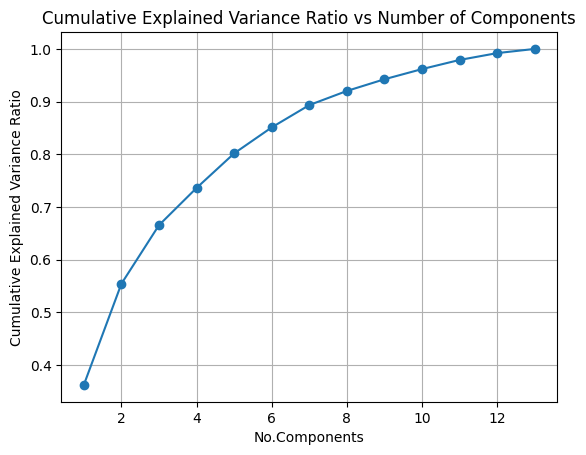

In [13]:
# instantiate the PCA and fit+transform the scaled data
pca = PCA()
pca.fit(scaled_feature_frame)
pca_data = pca.transform(scaled_feature_frame)
# get the cumulative variance ratio
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
print(cumulative_variance_ratio)
# plot the line for easier interpretation
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='-')
plt.xlabel('No.Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs Number of Components')
plt.grid(True)
plt.show()

We can see that with 8 components there is a Cumulative Explained Variance over 90% of the raw data, so i consider it to be an appropriate number of Principle components.

Trim the data down to just the first 8 components.

In [14]:
n_components = 8
# get only the first 8 components
reduced_dim_data = pca_data[:, :n_components]

Put the processed data back into a pandas dataframe so that it is easier to work with.

In [15]:
column_names = ["PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8"]
# put the data back into a data frame
reduced_dim_frame = pd.DataFrame(reduced_dim_data, columns=column_names)

Plot a scatter matrix to see the relationships between the new features.

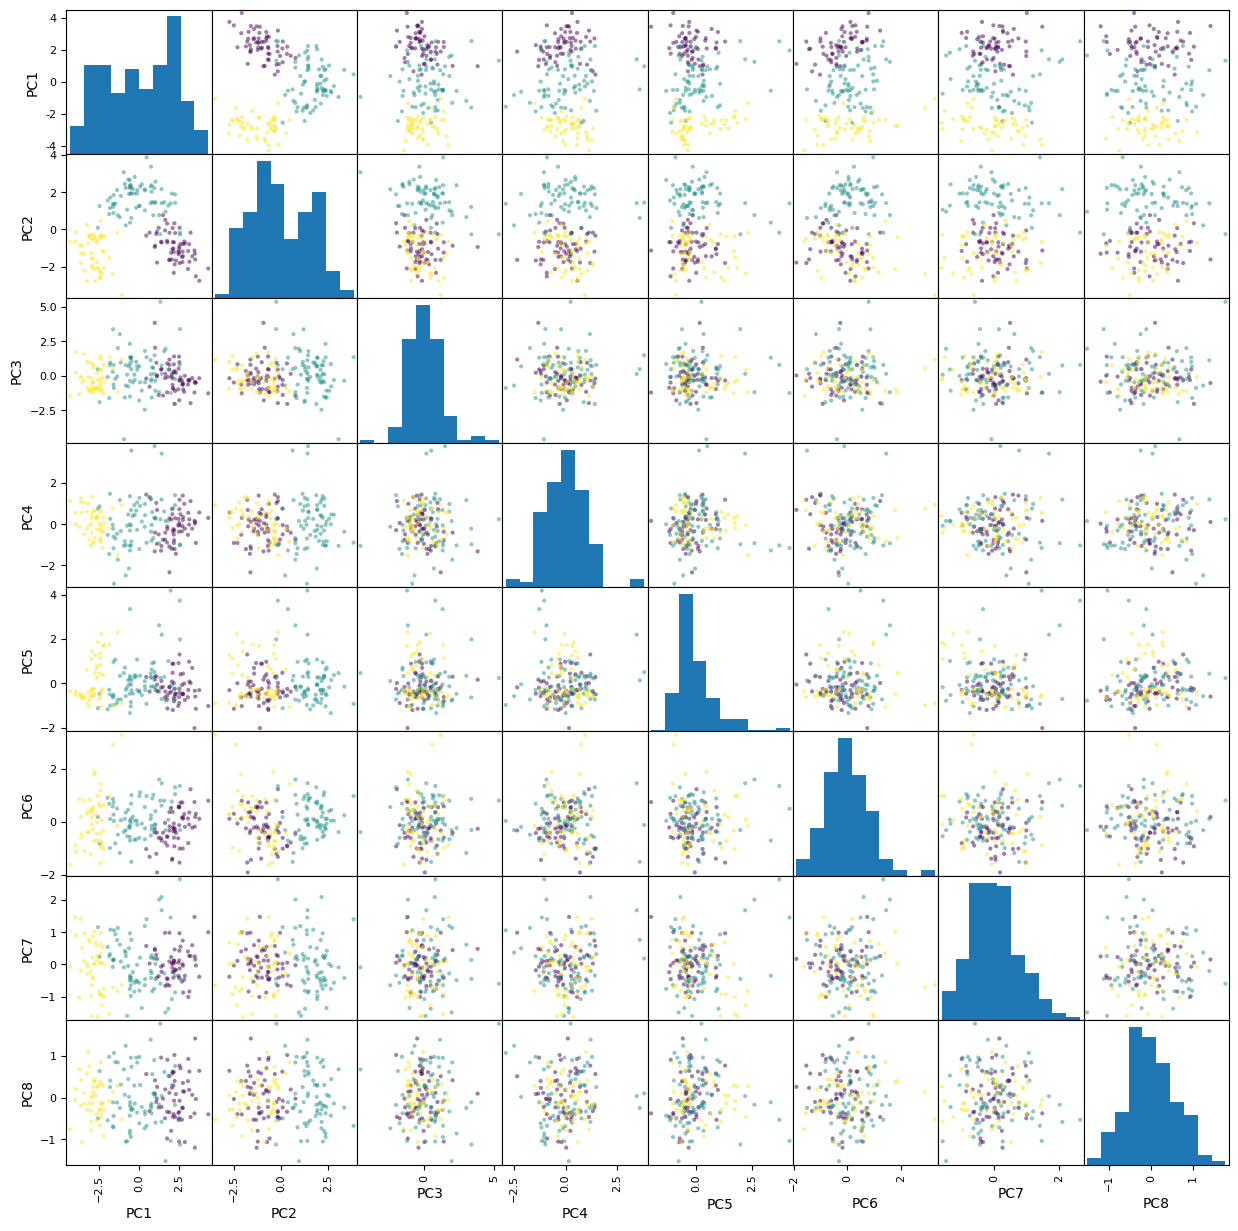

In [ ]:
pd.plotting.scatter_matrix(reduced_dim_frame, figsize=(15,15), c=label_frame);

From this we can see that the new principle components do a good job of seperating out the classes, so i am happy to continue with these components. PC1 and PC2 have very little overlap between classes so I am confident a decision tree will be an effective method to classify them.

## Decision Tree

Creating a 70/30 train test split, and ensuring that the training data is representative of the classes. I am choosing to do a 70/30 split as i found a 80/20 split was a bit too easy for the models to classify making it difficult to determine which was the best.

In [16]:
print(label_frame.value_counts(normalize=True))
train_feature_frame, test_feature_frame, train_label_frame, test_label_frame = train_test_split(reduced_dim_frame, label_frame, test_size=0.3)
train_label_frame.value_counts(normalize=True)

Target
2    0.398876
1    0.331461
3    0.269663
Name: proportion, dtype: float64


Target
2    0.387097
1    0.306452
3    0.306452
Name: proportion, dtype: float64

Instantiate a sklearn decision tree and fit it to the training data

In [17]:
# instantiate a decision tree and fit it on the training data
decision_tree = tree.DecisionTreeClassifier()
decision_tree = decision_tree.fit(train_feature_frame, train_label_frame)

use the trained tree to predict the test data and compare it to the true values. Then display the results in a confusion matrix

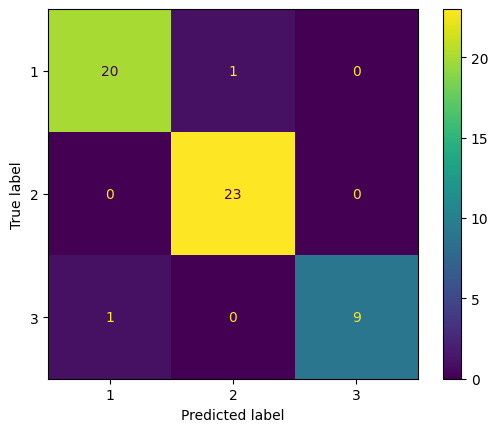

0.9629629629629629


In [18]:
# use the tree to predict the test data
predictions = decision_tree.predict(test_feature_frame)
# get the confusion matrix data
conf_matrix = confusion_matrix(test_label_frame, predictions, labels=decision_tree.classes_)
# visualize the confusion matrix data
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=decision_tree.classes_)
disp.plot()
plt.show()
print(accuracy_score(test_label_frame, predictions))

The tree seems to be over predicting class two, this could be a result of there being more 2 class samples in the training data, or it could simply be that a decision tree is not complex enough to differentiate certain cases. Slightly interestingly class 3 is also over predicted which has the least occurances, whats more it wrongly classifies the 2 class, so i don't believe that the composition of the classes is too big of a problem.

Now i will test if it is better to just go off the raw data by training a tree on the original feature frame. Like with the PCA tree, i will use a 70-30 split.

In [19]:
print(label_frame.value_counts(normalize=True))
train_feature_frame_origional, test_feature_frame_origional, train_label_frame_origional, test_label_frame_origional = train_test_split(feature_frame, label_frame, test_size=0.3)
train_label_frame_origional.value_counts(normalize=True)

Target
2    0.398876
1    0.331461
3    0.269663
Name: proportion, dtype: float64


Target
1    0.387097
2    0.370968
3    0.241935
Name: proportion, dtype: float64

fit a tree on the origional features.

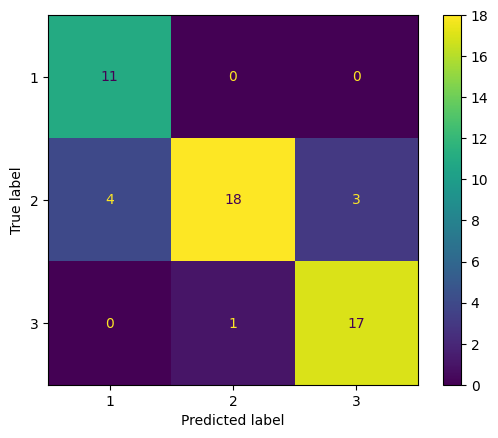

0.8518518518518519


In [20]:
# same as the other tree just using different data (this data is notably not even scaled as this shouldn't have an effect on a tree)
decision_tree_origional = tree.DecisionTreeClassifier()
decision_tree_origional = decision_tree_origional.fit(train_feature_frame_origional, train_label_frame_origional)
predictions_origional = decision_tree_origional.predict(test_feature_frame_origional)
conf_matrix_origional = confusion_matrix(test_label_frame_origional, predictions_origional, labels=decision_tree_origional.classes_)
disp_origional = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_origional, display_labels=decision_tree_origional.classes_)
disp_origional.plot()
plt.show()
print(accuracy_score(test_label_frame_origional, predictions_origional))

training on the origional data results in a worse accuracy, suggesting that it makes sense to use the PCA data instead. It should be noted that there is slightly different training test splits which could lead to the difference however I have run it a few times with different splits, and the PCA has always performed better. The difference in performance could potential be explained by more features allowing the tree to overfit [4]. This tree is having difficulty predicting class 2 as well, which is a tad strange, it could simply be a result of there being more class 2s in the test set, but there are only 5 more 2s than 3s so I find it hard to believe that is the cause.

Below i have printed out the tree trained on the PCA data, this could allow a human to run through it by hand if they really wanted, but also creates further insight into what makes the wines destinct. This could perhapse be used in marketing (to be honest i don't know enough about wine to say)

|--- feature_1 <= 0.54
|   |--- feature_0 <= -1.07
|   |   |--- feature_4 <= -1.10
|   |   |   |--- class: 2
|   |   |--- feature_4 >  -1.10
|   |   |   |--- class: 3
|   |--- feature_0 >  -1.07
|   |   |--- feature_4 <= 1.64
|   |   |   |--- feature_7 <= 1.14
|   |   |   |   |--- class: 1
|   |   |   |--- feature_7 >  1.14
|   |   |   |   |--- feature_4 <= -0.59
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- feature_4 >  -0.59
|   |   |   |   |   |--- class: 2
|   |   |--- feature_4 >  1.64
|   |   |   |--- class: 2
|--- feature_1 >  0.54
|   |--- class: 2



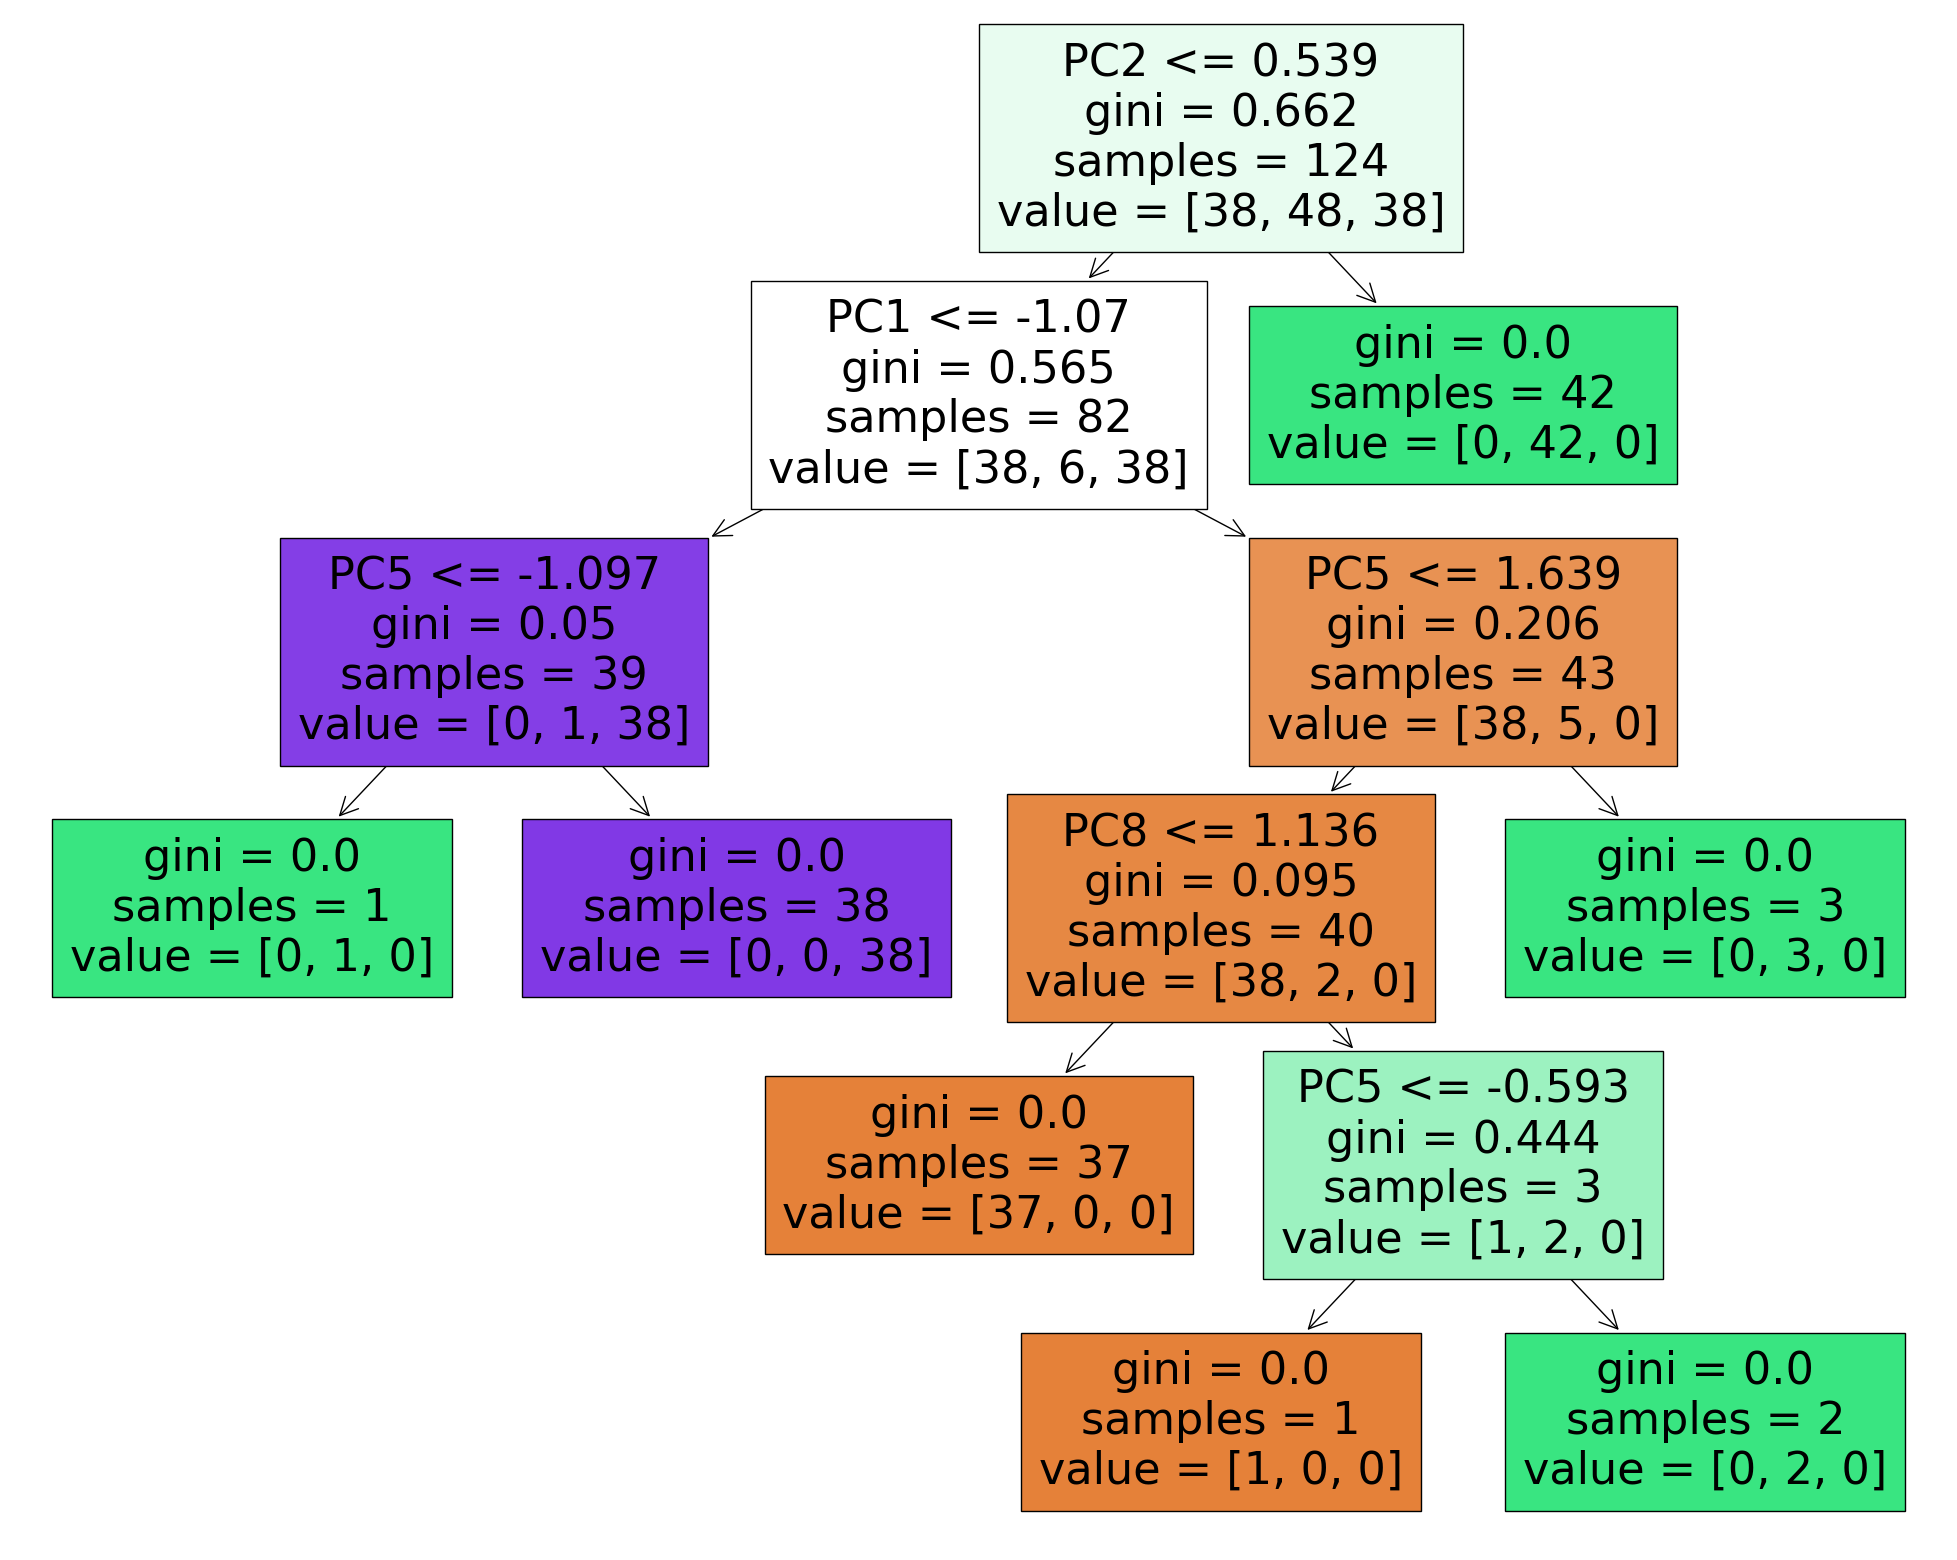

In [21]:
print(export_text(decision_tree))
fig = plt.figure(figsize=(25,20))
# plot a diagram of the tree
tree.plot_tree(decision_tree, feature_names=train_feature_frame.columns, filled=True)
plt.show()

Having looked at the tree, I can see that PC2 is rather important as is PC1, which backs up my hypothesis from the PCA scatter matrix. I can also see that there are a few leaves with only one sample, which is a bit of a red flag for overfitting, upping the min_samples value could potentially reduce this.

Even though the tree trained on the PCA data had a higher accuracy, I may be able to gain more useful insight from the one trained on the origional data, so i will plot that one as well.

|--- feature_12 <= 755.00
|   |--- feature_11 <= 2.09
|   |   |--- feature_3 <= 17.40
|   |   |   |--- class: 2
|   |   |--- feature_3 >  17.40
|   |   |   |--- class: 3
|   |--- feature_11 >  2.09
|   |   |--- feature_8 <= 0.82
|   |   |   |--- class: 3
|   |   |--- feature_8 >  0.82
|   |   |   |--- feature_0 <= 13.17
|   |   |   |   |--- class: 2
|   |   |   |--- feature_0 >  13.17
|   |   |   |   |--- feature_7 <= 0.30
|   |   |   |   |   |--- class: 2
|   |   |   |   |--- feature_7 >  0.30
|   |   |   |   |   |--- class: 1
|--- feature_12 >  755.00
|   |--- feature_10 <= 0.77
|   |   |--- class: 3
|   |--- feature_10 >  0.77
|   |   |--- class: 1



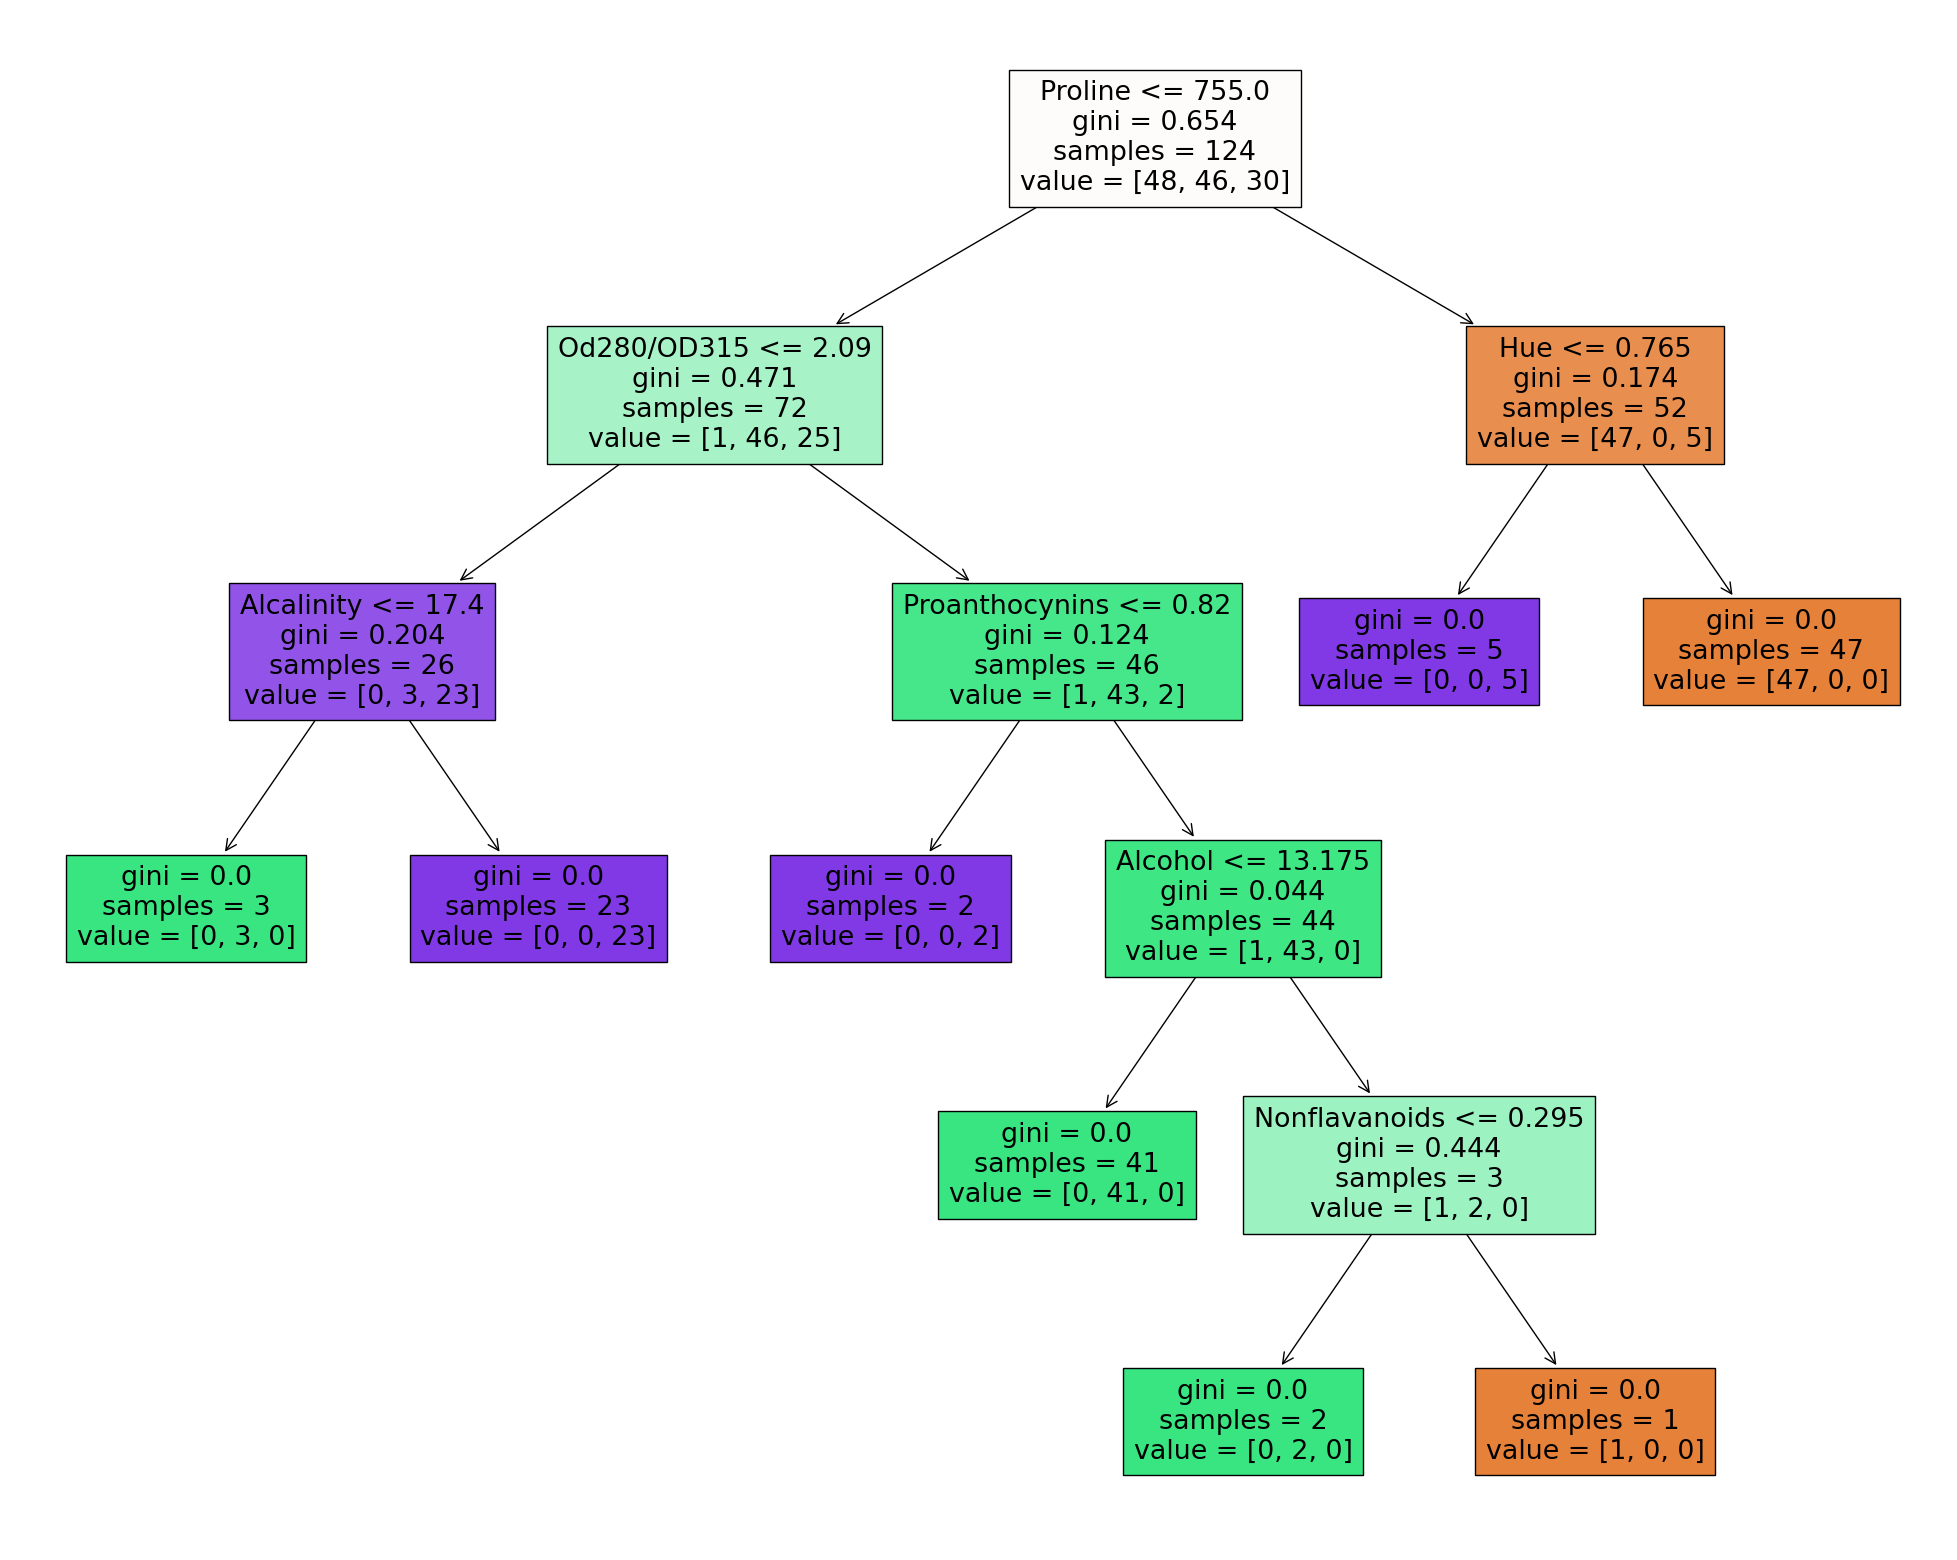

In [23]:
print(export_text(decision_tree_origional))
fig = plt.figure(figsize=(25,20))
# plot a diagram of the tree
tree.plot_tree(decision_tree_origional, feature_names=train_feature_frame_origional.columns, filled=True)
plt.show()

From this I can see that Proline, Hue and Od280/OD315 are the most important features, which was a little unexpected, I had thought that Flavanoids would play a larger role. And judging by the number of samples in the leaves there doesn't seem to be anything to suggest that this would be overfitting more than the PCA tree, so it my unfortunatly be that the test train split on this particular run wasn't as good as the PCA's.

## Random Forest

Random forests use multiple trees to check for slightly different things, this can allow for far more nuance, but can also lead to overfitting.

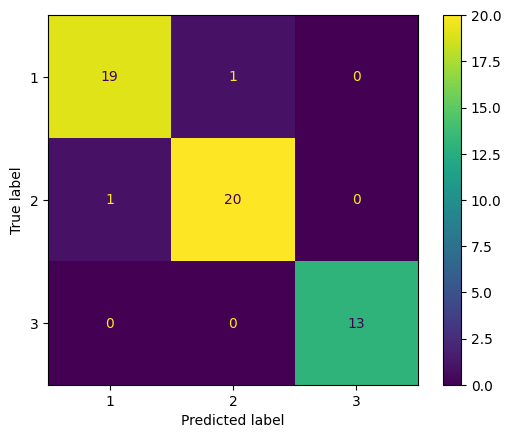

0.9629629629629629


In [ ]:
# instantiate a random forest and fit it to the training data
forest = RandomForestClassifier(max_depth=2, n_estimators=50, random_state=0)
forest = forest.fit(train_feature_frame, train_label_frame)
# make predictions
predictions = forest.predict(test_feature_frame)
# create a confusion matrix
conf_matrix = confusion_matrix(test_label_frame, predictions, labels=forest.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=forest.classes_)
disp.plot()
plt.show()
print(accuracy_score(test_label_frame, predictions))

This is not outperforming a single tree, so i assume that it is overfitting, i have tweaked the hyper parameters to try to avoid it, however it isn't improving the accuracy a significant amount to justify the extra computation, I will try again using adaBoost to see if it helps at all. adaBoost can improve a model by making subsiquent trees with a weighting to incorrectly classified samples. [1]

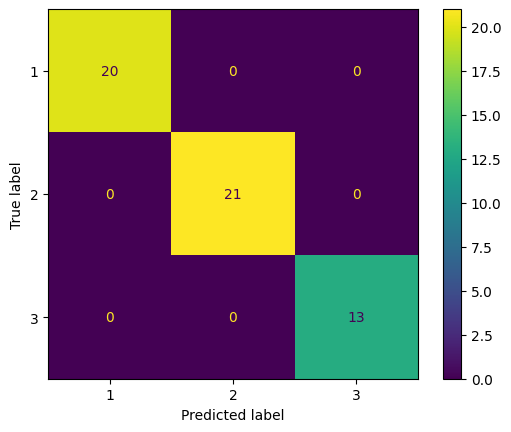

1.0


In [ ]:
# create a AdaBoostClassifier with 100 estimators
adaForest = AdaBoostClassifier(n_estimators=100, algorithm="SAMME")
adaForest = adaForest.fit(train_feature_frame, train_label_frame)
predictions = adaForest.predict(test_feature_frame)
conf_matrix = confusion_matrix(test_label_frame, predictions, labels=adaForest.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=adaForest.classes_)
disp.plot()
plt.show()
print(accuracy_score(test_label_frame, predictions))

This is clearly a very good outcome. In my opinion the extra computation to run the adaBoost tree would be worth it to get a higher accuracy. That said the higher performance over a random forest can probably be largely attributed to having 100 estimators instead of 50, however, it does have a depth of 1 so the actual number of computations is the same or at least should be close, as there are twice as many trees but half as many comparisions for each tree.

# 4. Conclusion
From my tests I believe that the adaBoosted model trained on PCA data would be the best fit to classify the origin of the wines, being able to score 100% accuracy on a 70-30 train-test split. Though it takes more computation than a single tree and doesn't have the advantage of being able to be traced by hand like a decision tree, I think that a high accuracy out weighs these draw backs.<br/><br/>
## Key Insights
Should someone want to try to classify a wine, without one of the models or without access to all the measurements, they would do best to look into Hue, Colour, OD280/OD315 according to the decision tree, though I do still believe that flavanoids can be an important feature particularly if paired with OD280/OD315. However if they do have access to my models and all the features, they would be best off running it through the AdaBoost classifier.

## On the Dataset
Whilst I am happy with the insights gained from this dataset a larger one would be important to gain more valuable information in the future. To improve realiablity simply more samples would be usefull especially more class 3 samples. But to improve funtionality, adding wine from more cultivars would be good to further the model's ability to identify fake wines. From there, potentially very valuable knowledge could be gained by including something to say how much someone who like wine x liked wine y, this would allow for more accurate marketing.

## Possible Improvements To My implementation
If I were to make some improvements so this project, I would likely set a seed for any randomizers to make testing / comparing different models more fair. <br/>
I would also be more inclined to try an MLP, the reason i didn't is because I was happy with the performance of the AdaBoosted classifier, however it may be interesting to see if it could compete.
<br/>
Finally when comparing the models, it could be a good idea to train and test the same model multiple times on different splits, and then get an average, especially if I can't fix random values, as perfomances varied a fair bit between different runs, perhapse use of k-folds could be a good option here to reduce the luck involved in the train-test split.

# 5. References
[1] Yoav Freund and Robert E. Schapire. 1995. A desicion-theoretic generalization of on-line learning and an application to boosting. In Computational Learning Theory, 1995. Springer, Berlin, Heidelberg, 23–37. https://doi.org/10.1007/3-540-59119-2_166 <br/>
[2] Jong Woo Kim, Byung Hun Lee, Michael J. Shaw, Hsin-Lu Chang, and Matthew Nelson. 2001. Application of Decision-Tree Induction Techniques to Personalized Advertisements on Internet Storefronts. International Journal of Electronic Commerce 5, 3 (March 2001), 45–62. https://doi.org/10.1080/10864415.2001.11044215 <br/>
[3] John Daab. 2011. The Case of the Questionable Jeffersonian Lafites: Forensic Applications in Detecting Wine Fraud. J. Art Crime 5, (2011), 3. <br/>
[4] Icamaan B. Viegas da Silva and Paulo J. L. Adeodato. 2011. PCA and Gaussian noise in MLP neural network training improve generalization in problems with small and unbalanced data sets. In The 2011 International Joint Conference on Neural Networks, July 2011. 2664–2669. https://doi.org/10.1109/IJCNN.2011.6033567




small note to marker, sorry, i forgot to seperate out the discussion on the models performance and just did it in the building the model section, this is partly because it felt a bit more natural but also because i was trying to further develop the models and needed to look into the performance to make informed decisions.